In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish

In [3]:
from gym_fish.envs.lib import pyflare as fl

In [4]:
Experiment_name = '90 degree servo control EMPIRICAL mass10 2_30 WP 1.0 wr 0.0 wa0.0'
Experiment_note = "change rotation reward"

In [5]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/home/liuwj/codes/pytorch_fish


### Import Settings

In [6]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [7]:
fluid_json = json_folder+'fluid_param_0.5.json'
rigid_json = json_folder+'rigids_2_30.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/home/liuwj/codes/pytorch_fish/py_data/jsons/fluid_param_0.5.json
/home/liuwj/codes/pytorch_fish/py_data/jsons/rigids_2_30.json
/home/liuwj/codes/pytorch_fish/py_data/jsons/paths/line.json


In [8]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    # plt.show()

### Output Settings

In [9]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [10]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from video import VideoRecorder
from logger import Logger
from agent.replay_buffer import ReplayBuffer
from agent import utils

## RL Begin

In [12]:
from gym_fish.envs import FishEnv
env = gym.make('fish-v0',
                  gpuId=0,
                       path_json=path_json,
                        couple_mode= fl.COUPLE_MODE.EMPIRICAL,
                         theta = 90,frame_skip=100,
                       fluid_json=fluid_json,wp=1.0,wr=0.0,wa=0.0,
                       rigid_json=rigid_json,
                   )

0
0
[0.97686249 2.00028078 2.99999994] [ 9.99980604e-01 -6.22825676e-03  2.04357705e-06] [0.97686249 2.00028078 4.99999994] [6.123234e-17 0.000000e+00 1.000000e+00]


In [13]:
from agent.sac import SACAgent
from agent.critic import DoubleQCritic
from agent.actor import DiagGaussianActor

In [14]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [15]:
num_train_steps=1e6
replay_buffer_capacity=5000
num_seed_steps=256
eval_frequency=1000
num_eval_episodes=5
device="cuda"
# logger
log_frequency=10000
log_save_tb=True
# video recorder
save_video=False
seed=1

In [16]:
# agent settings
obs_dim=env.observation_space.shape[0] # to be specified later
action_dim=env.action_space.shape[0] # to be specified later
action_range=[
        float(env.action_space.low.min()),
        float(env.action_space.high.max())
    ] # to be specified later
discount=0.99
init_temperature=0.1
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
actor_update_frequency=1
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
critic_target_update_frequency=2
batch_size=128
learnable_temperature=True

# critic settings
critic_hidden_dim=128
critic_hidden_depth=2
# actor settings
actor_hidden_depth=2
actor_hidden_dim=128
actor_log_std_bounds=[-5, 2]


critic_network = DoubleQCritic(obs_dim,action_dim,critic_hidden_dim,critic_hidden_depth)

actor_network = DiagGaussianActor(obs_dim,action_dim,actor_hidden_dim,actor_hidden_depth,actor_log_std_bounds)

replay_buffer = ReplayBuffer(env.observation_space.shape,
                                         env.action_space.shape,
                                          int(replay_buffer_capacity),
                                         device)

agent = SACAgent(obs_dim,action_dim,action_range,device,critic_network,actor_network,replay_buffer,discount,init_temperature,alpha_lr,alpha_betas,actor_lr,actor_betas,actor_update_frequency,critic_lr,critic_betas,critic_tau,critic_target_update_frequency,batch_size,learnable_temperature)

In [17]:
evaluate_save_data = False
evaluate_save_fluid = False



In [18]:
class Workspace(object):
    def __init__(self,env):
        self.work_dir = os.getcwd()
        print(f'workspace: {self.work_dir}')

        self.num_eval_episodes= num_eval_episodes
        self.num_train_steps = num_train_steps
        self.num_seed_steps = num_seed_steps
        self.eval_frequency=eval_frequency

        self.logger = Logger(tb_folder,
                             save_tb=log_save_tb,
                             log_frequency=log_frequency,
                             agent="sac")

        utils.set_seed_everywhere(seed)
        self.device = torch.device(device)
        self.env = env
        self.evaluate_save_data =evaluate_save_data
        self.evaluate_save_fluid =evaluate_save_fluid
        self.agent = agent


        # self.video_recorder = VideoRecorder(
        #     self.work_dir if save_video else None)
        self.step = 0
        self.next_eval_steps= self.eval_frequency

    def evaluate(self):
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(self.step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(self.step)
        model_path = model_folder+"steps_{0}".format(self.step)
        # save model
        self.agent.save(model_path)
        best_rewards = -9999
        for episode in range(self.num_eval_episodes):
            print("Evaluating episode " + str(episode) +" ....")
            obs = self.env.reset()
            self.agent.reset()
            # self.video_recorder.init(enabled=(episode == 0))
            done = False
            episode_reward = 0
            infos = []
            while not done:
                with utils.eval_mode(self.agent):
                    action = self.agent.act(obs, sample=False)
                if self.evaluate_save_data:
                    obs, reward, done, info = self.env.stepSave(action,save_fluid=self.evaluate_save_fluid)
                else:
                    obs, reward, done, info = self.env.step(action)
                infos.append(info)
                # self.video_recorder.record(self.env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(self.step),reward_fig_name=reward_fig_name)
                env.plot3d(title=str(self.step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # self.video_recorder.save(f'{self.step}.mp4')
        average_episode_reward /= self.num_eval_episodes
        self.logger.log('eval/episode_reward', average_episode_reward,
                        self.step)
        self.logger.dump(self.step)

    def run(self):
        episode, episode_reward, done = 0, 0, True
        start_time = time.time()
        while self.step < self.num_train_steps:
            if done:
                if self.step > 0:
                    self.logger.log('train/duration',
                                    time.time() - start_time, self.step)
                    start_time = time.time()
                    self.logger.dump(
                        self.step, save=(self.step > self.num_seed_steps))

                # evaluate agent periodically
                if self.step > 0 and self.step >=self.next_eval_steps:
                    self.logger.log('eval/episode', episode, self.step)
                    self.next_eval_steps = self.next_eval_steps+self.eval_frequency
                    self.evaluate()

                self.logger.log('train/episode_reward', episode_reward,
                                self.step)

                obs = self.env.reset()
                self.agent.reset()
                done = False
                episode_reward = 0
                episode_step = 0
                episode += 1

                self.logger.log('train/episode', episode, self.step)

            # sample action for data collection
            if self.step < self.num_seed_steps:
                action = self.env.action_space.sample()
            else:
                with utils.eval_mode(self.agent):
                    action = self.agent.act(obs, sample=True)

            # run training update
            if self.step >= self.num_seed_steps:
                self.agent.update(self.logger, self.step)

            next_obs, reward, done, _ = self.env.step(action)

            # allow infinite bootstrap
            done = float(done)
#             done_no_max = 0 if episode_step + 1 == self.env._max_episode_steps else done
            done_no_max = done
            episode_reward += reward

            self.agent.replay_buffer.add(obs, action, reward, next_obs, done,
                                   done_no_max)

            obs = next_obs
            episode_step += 1
            self.step += 1


### RL Train

In [19]:
!./clean_visdata.sh

rm: 无法删除'./data/vis_data/Objects/*': 没有那个文件或目录
rm: 无法删除'./data/vis_data/Fluid/*': 没有那个文件或目录


In [20]:
ws = Workspace(env)

workspace: /home/liuwj/codes/pytorch_fish


0
[0.97686249 2.00028078 2.99999994] [ 9.99980604e-01 -6.22825676e-03  2.04357705e-06] [0.97686249 2.00028078 4.99999994] [6.123234e-17 0.000000e+00 1.000000e+00]
0
[0.97686249 2.00028078 2.99999994] [ 9.99980604e-01 -6.22825676e-03  2.04357705e-06] [0.97686249 2.00028078 4.99999994] [6.123234e-17 0.000000e+00 1.000000e+00]
0
[0.97686249 2.00028078 2.99999994] [ 9.99980604e-01 -6.22825676e-03  2.04357705e-06] [0.97686249 2.00028078 4.99999994] [6.123234e-17 0.000000e+00 1.000000e+00]
0
[0.97686249 2.00028078 2.99999994] [ 9.99980604e-01 -6.22825676e-03  2.04357705e-06] [0.97686249 2.00028078 4.99999994] [6.123234e-17 0.000000e+00 1.000000e+00]
0
[0.97686249 2.00028078 2.99999994] [ 9.99980604e-01 -6.22825676e-03  2.04357705e-06] [0.97686249 2.00028078 4.99999994] [6.123234e-17 0.000000e+00 1.000000e+00]
0
[0.97686249 2.00028078 2.99999994] [ 9.99980604e-01 -6.22825676e-03  2.04357705e-06] [0.97686249 2.00028078 4.99999994] [6.123234e-17 0.000000e+00 1.000000e+00]
| train | E: 6 | S: 30

0
[0.97686249 2.00028078 2.99999994] [ 9.99980604e-01 -6.22825676e-03  2.04357705e-06] [0.97686249 2.00028078 4.99999994] [6.123234e-17 0.000000e+00 1.000000e+00]


KeyboardInterrupt: 

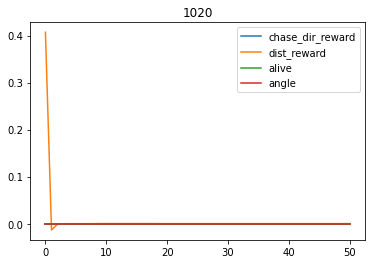

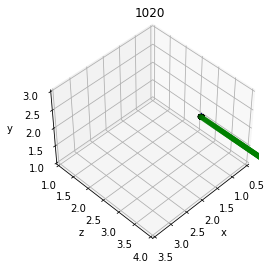

In [21]:

ws.run()

In [22]:
ws.agent.load('/home/liuwj/codes/pytorch_fish/output_data/2021-01-10/90 degree servo control EMPIRICAL mass10 2_30 WP 1.0 wr 0.0 wa0.0_2021-01-10 11:53/networks/SAC/models/steps_1020')

In [24]:
len(ws.agent.replay_buffer)

1020

In [25]:
ws.agent.replay_buffer.obses

array([[-7.71250250e-03, -2.94859547e-07,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  2.04357707e-06],
       [-1.12453913e-02, -1.18681386e-01, -1.89425573e-02, ...,
        -1.43042281e-02,  9.12910402e-01, -4.08160001e-01],
       [-1.10882884e-02, -1.20482907e-01, -1.89425573e-02, ...,
        -1.43042281e-02,  9.11986589e-01, -4.10220027e-01],
       ...,
       [-2.38444284e-02, -2.27430966e-02,  1.22401174e-02, ...,
        -9.61361174e-03, -2.64923684e-02,  2.87850760e-02],
       [-2.19199304e-02,  2.73688659e-02, -7.04725645e-03, ...,
        -2.25080941e-02, -2.66585667e-02, -7.45711382e-03],
       [ 2.26055179e-02, -2.74944957e-02, -2.51811929e-02, ...,
        -2.16442160e-02,  2.13681385e-02,  9.85135976e-03]], dtype=float32)